# Esselunga online shop scraping

Product names, prices per unit and prices per kg/liter, nutritional information.

Purpose: help calculating price and convenience of meals and diets, for example knowing which are the cheapest products per gram of protein (€/grams of protein) or per calories (€/cal).

## Initial data scraping

The initial scraping has been done manually, just going to every category of the online shop and launching a JS script to get to the bottom of the infinite scroll. This triggers all the xhr requests. Then, the JSON responses for every category have been saved to `*.har` files by right-clicking and selecting _"Save All As HAR"_.

### JS autoscroll code

from https://www.quora.com/Is-there-a-way-to-automatically-load-a-page-with-infinite-scroll-until-it-gets-to-the-bottom-of-the-feed-Is-there-a-software-or-a-setting-that-helps-to-do-this

```var lastScrollHeight = 0;
function autoScroll() {
  var sh = document.documentElement.scrollHeight;
  if (sh != lastScrollHeight) {
    lastScrollHeight = sh;
    document.documentElement.scrollTop = sh;
  }
}
window.setInterval(autoScroll, 100);```

## Parse responses

In [1]:
import re, os, json

def label_to_price_per_kg(label):
    regex = r'Euro (\d+,\d+) \/ ([a-z]+)'
    match = re.match(regex, label)
    
    if not match:
        return None
    
    groups = list(match.groups())
    price_per_kg = float(groups[0].replace(',', '.'))
    
    # Adjust price per kg if necessary
    if groups[1] == 'g' or groups[1] == 'ml':
        price_per_kg *= 1000
    elif groups[1] == 'hg':
        price_per_kg *= 10
    elif groups[1] == 'pz':
        price_per_kg = None
    
    return price_per_kg

def parse_har(har_filename):
    # Parse har as json
    with open('har/{}'.format(har_filename)) as f:
        js = json.loads(f.read())
    
    # Iterate over responses and get all the entities
    entities = []
    for entry in js['log']['entries']:
        response = json.loads(entry['response']['content']['text'])
        entities.extend(response['entities'])
        
    for entity in entities:
        # Strip description
        entity['description'] = entity['description'].strip()
        
        # Calculate price per kg by parsing the label
        entity['price_per_kg'] = label_to_price_per_kg(entity['label'])
        
        # Add qty
        entity['qty'] = ' '.join([entity['unitValue'], entity['unitText']])
        
        # Add category
        entity['category'] = har_filename[:-4]
        
    # Only keep products with price per kg
    entities = list(filter(lambda entity: entity['price_per_kg'], entities))
    
    # Keep only interesting keys
    keys_to_keep = ['description', 'category', 'price', 'qty', 'price_per_kg']
    
    # Create dictionary with product id as key
    entities = { entity['id'] : { k: entity[k] for k in keys_to_keep } for entity in entities }
    
    return entities

## Build database from HARs

In [2]:
import pandas as pd

entities = {}
for har_filename in next(os.walk('har'))[2]:
    entities.update(parse_har(har_filename))

## Scrape nutrition facts from IDs

The `nutrition_facts` dictionary has the same keys as `entities`.
If the value is `repeat`, it means the request has failed for some reason and needs to be repeated.
Otherwise, if the response has status code 200 OK, the value would be the text of the response.
Initially, the dictionary is created by copying `entities` and setting all the keys to `repeat`.

This is done so that the data can be scraped in multiple passes without losing intermediate results, because after about half of the request I noticed my IP address has been 'banned' and every request ended in timeout.

The code below opens and reads the dictionary in the JSON file and tries to make requests to the Esselunga online shop website to scrape nutritional information. To do so, first make a valid request from the browser in order to obtain valid cookies and headers for the request.

## Parse nutrition facts

In [3]:
def delete_nutrition_facts_by_id(_id):
    nutrition_facts = json.loads(open('nutrition_facts/nutrition_facts.json', 'r').read())
    
    nutrition_facts.pop(str(_id))
    
    with open('nutrition_facts/nutrition_facts.json', 'w') as f:
        f.write(json.dumps(nutrition_facts))

def parse_table(_id):
    return pd.read_html(nutrition_facts[_id])[0]

def parse_nutrition_facts(nutrition_facts):
    # Find tables containing nutritional info.
    missing = 0
    for _id in nutrition_facts.keys():
        found = False
        for idx, el in enumerate(nutrition_facts[_id]['informations']):
            if 'value' in el and 'Informazioni nutrizionali' in el['value']:
                nutrition_facts[_id] = el['value']
                found = True
                break
                    
        if not found:
            nutrition_facts[_id] = None
            missing += 1
    
    # Fill missing keys with None.
    for _id in entities.keys():
        if str(_id) not in nutrition_facts:
            nutrition_facts[_id] = None
            missing += 1
            
    # Now 'entities' and 'nutrition_facts' have the same keys.
    print('{} total entities. {} are missing nutrition facts.'.format(len(nutrition_facts), missing))
    
    # Convert str keys to int keys
    nutrition_facts = { int(_id) : fact for _id, fact in nutrition_facts.items() }
    
    # Parse raw HTML table and extract data
    for _id, html in nutrition_facts.items():
    
        if html is None:
            continue
        
        # Parse table
        table = pd.read_html(html)[0]
        
        # Identify columns in table: labels ('nutrizionali') and values per 100g
        cols_nutrizionali = [col for col in table.columns if 'nutrizionali' in col]
        cols_100 = [col for col in table.columns if '100' in col]
        
        # If either column is not found, forget the nutrition facts for this item
        if not cols_nutrizionali:
            nutrition_facts[_id] = None
            continue
        
        if not cols_100:
            nutrition_facts[_id] = None
            continue
            
        col_nutrizionali = cols_nutrizionali[0]
            
        # Get calories separately because the corresponding label is not always consistent
        # col_100 will be the one where kcal are found
        regexes = [r'(\d+),?\d*? *kcal', r'kcal *(\d+)']
        matches = pd.DataFrame()
        
        it = iter([(col, regex) for col in cols_100 for regex in regexes])

        col_regex = None
        while matches.empty:
            try:
                col_regex = next(it)
            except StopIteration:
                break
            
            matches = table[col_regex[0]].astype(str).str.extract(col_regex[1], flags=re.IGNORECASE).dropna()
        
        col_100 = col_regex[0]
        kcal = int(matches[0].tolist()[0])
        
        d = {}
        d['kcal'] = kcal
        
        keywords = ['carboidrati', 'zuccheri', 'proteine', 'grassi', 'saturi', 'monoinsaturi', 'polinsaturi', 'fibre', 'sale']
        translate = {'carboidrati' : 'carbs',
                     'zuccheri': 'sugars',
                     'proteine': 'protein',
                     'grassi': 'fat',
                     'saturi': 'saturated',
                     'monoinsaturi': 'monounsat.',
                     'polinsaturi': 'polyunsat.',
                     'fibre': 'fiber',
                     'sale': 'salt'}
        
        # For each keyword, find it in 'col_nutrizionali' and get the corresponding value in 'col_100'
        for keyword in keywords:
            found = list(table[table[col_nutrizionali].str.contains(keyword, case=False).fillna(False)][col_100])
            
            if not found:
                continue
                
            found = found[0]
            
            if isinstance(found, float) or isinstance(found, int):
                d[translate[keyword]] = float(found)
                continue

            if isinstance(found, str):
                found = found.replace(',', '.').strip()
            
            numeric_const_pattern = '[-+]? (?: (?: \d* \. \d+ ) | (?: \d+ \.? ) )(?: [Ee] [+-]? \d+ ) ?'
            rx = re.compile(numeric_const_pattern, re.VERBOSE)
            parsed = rx.findall(found)
                    
            if not parsed:
                d[translate[keyword]] = float(0)
            else:
                d[translate[keyword]] = float(parsed[0])
                    
        nutrition_facts[_id] = d
    
    return nutrition_facts

nutrition_facts = json.loads(open('nutrition_facts/nutrition_facts.json', 'r').read())
nutrition_facts = parse_nutrition_facts(nutrition_facts)

6179 total entities. 1253 are missing nutrition facts.


## Merge with database

In [4]:
# First make sure keys are exactly the same
assert set(entities.keys()) == set(nutrition_facts.keys())

# Merge things
for _id in entities.keys():
    
    d = nutrition_facts[_id]
    
    if d is not None:
        entities[_id].update(d)

## Sanity check

In [5]:
import math

tols = [5.0, 10.0, 20.0, 50.0, 100.0]
count = [0, 0, 0, 0, 0]
diffs = []

for _id, entity in entities.items():
    kcal_actual = entity.get('kcal', 0.0)
    kcal_calculated = 4 * entity.get('carboidrati', 0.0) + 4 * entity.get('proteine', 0.0) + 9 * entity.get('grassi', 0.0) + 1.5 * entity.get('fibre', 0.0)
    
    if not math.isnan(kcal_calculated):
        diffs.append(abs(kcal_actual - kcal_calculated))
    
    for i, tol in enumerate(tols):
        if not math.isclose(kcal_actual, kcal_calculated, abs_tol=tol):
            count[i] += 1

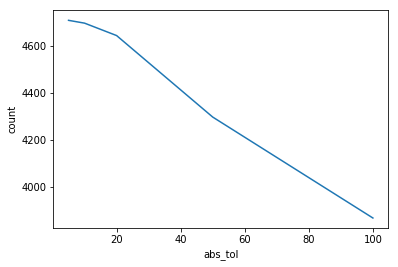

In [13]:
import matplotlib.pyplot as plt

plt.plot(tols, count)
plt.xlabel('abs_tol')
plt.ylabel('count')
plt.show()

Most products are within 20 calories of the calculated ones.

Most of the products which are **not** are _weird candy with polyols_.

Some of them are blatant errors though. Let's remove them.

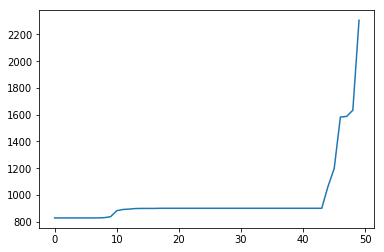

In [7]:
diffs.sort()
plt.plot(diffs[-50:])
plt.show()

In [8]:
to_remove = [5416230, 5416233, 5399643, 5427633, 5758337, 5417410, 5759062, 5417420, 5410182, 5724116, 5717056, 5409164, 5410135, 5405325, 5381793]

for _id in to_remove:
    entities.pop(_id)

## Add useful data

In [11]:
for entity in entities.values():
    entity.update( { '€/kcal' : (entity['price_per_kg'] / 10.0) / entity['kcal'] if 'kcal' in entity and entity['kcal'] != 0.0 else 0.0,
                     '€/g carb' : (entity['price_per_kg'] / 10.0) / entity['carbs'] if 'carbs' in entity and entity['carbs'] != 0.0 else 0.0,
                     '€/g protein' : (entity['price_per_kg'] / 10.0) / entity['protein'] if 'protein' in entity and entity['protein'] != 0.0 else 0.0,
                     '€/g fat' : (entity['price_per_kg'] / 10.0) / entity['fat'] if 'fat' in entity and entity['fat'] != 0.0 else 0.0} )

## Save to csv

In [12]:
df = pd.DataFrame(entities)
df = df.transpose()
df.to_csv('csv/esselunga.csv')